In [115]:
import sys 
sys.path.append('/Users/patroklos/Desktop/delphi_')

import torch as ch
from torch import Tensor
from torch.distributions import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence
import pandas as pd
import statsmodels.api as sm 
import seaborn as sns
import matplotlib.pyplot as plt
import IPython 

from delphi.distributions.normal import CensoredNormal
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader

In [116]:
args = Parameters({ 
    'samples': 1000, 
    'batch_size': 1, 
    'tol': 1e-1, 
    'lr': 1e-1, 
    'out_dir': '/Users/patroklos/Desktop/exp/censored',
    'exp': 'boston_bootstrap', 
    'trials': 20,
    'var': 10,
    'table_name': 'logs',
    'data_path': '/Users/patroklos/Desktop/Censored-Normal-Distributions/data/BostonHousing.csv'
})

# Load in the Boston Housing Dataset

In [117]:
df = pd.read_csv(args.data_path)
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [118]:
# remove chas because it is categorical data
col_list = list(df.columns)
col_list.remove('chas')
print("col list: ", col_list)

col list:  ['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat', 'medv']


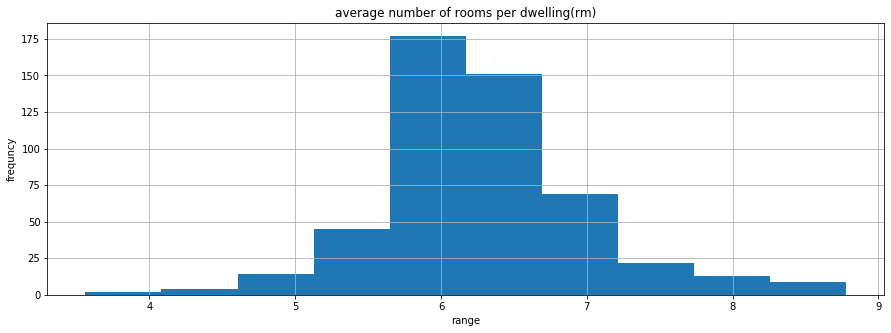

In [5]:
#defining fig size
fig= plt.figure(figsize=(15,5))
#plotting histogram of rm feature - average number of rooms per dwelling.
plt.hist(df["rm"])
plt.xlabel("range")
plt.ylabel("frequncy")
plt.title("average number of rooms per dwelling(rm)")
plt.grid()
plt.show()

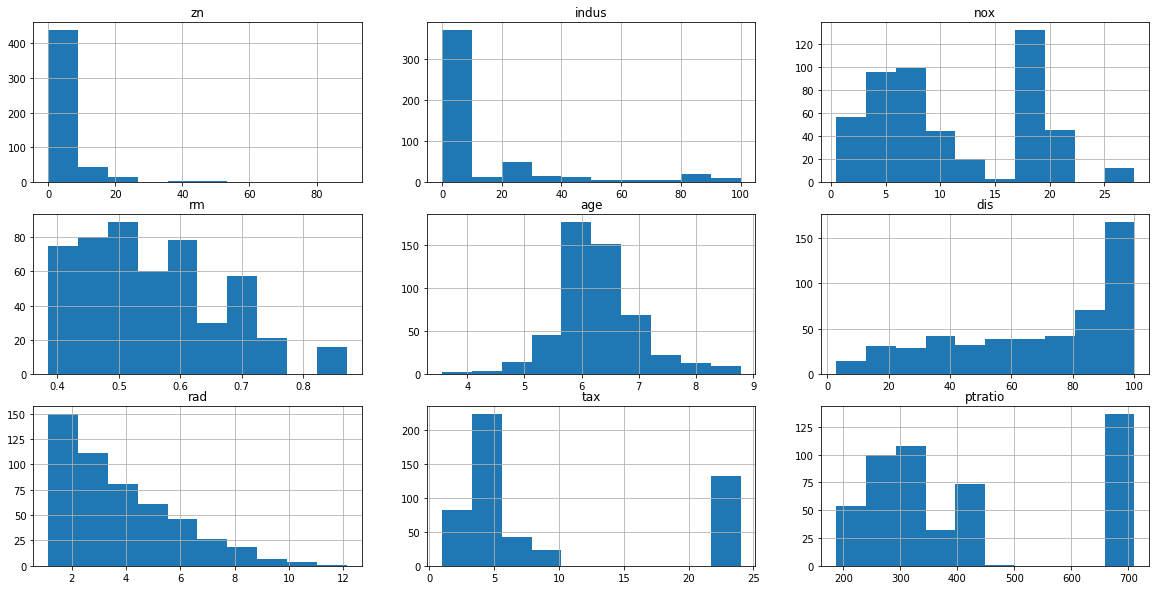

In [6]:
#subplots
fig, axs = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(20, 10)
cnt = 0
for i in range(0,3):
    for j in range(0,3):
        ax = axs[i][j]
        ax.hist(df[col_list[cnt]]); cnt += 1
        ax.set_title(col_list[cnt])
        ax.grid()

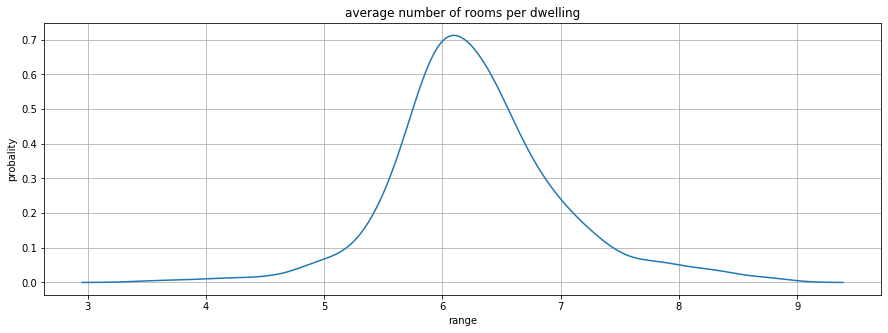

In [7]:
fig= plt.figure(figsize=(15,5))
sns.kdeplot(data=df["rm"])
plt.xlabel("range")
plt.ylabel("probality")
plt.title("average number of rooms per dwelling")
plt.grid()
plt.show()

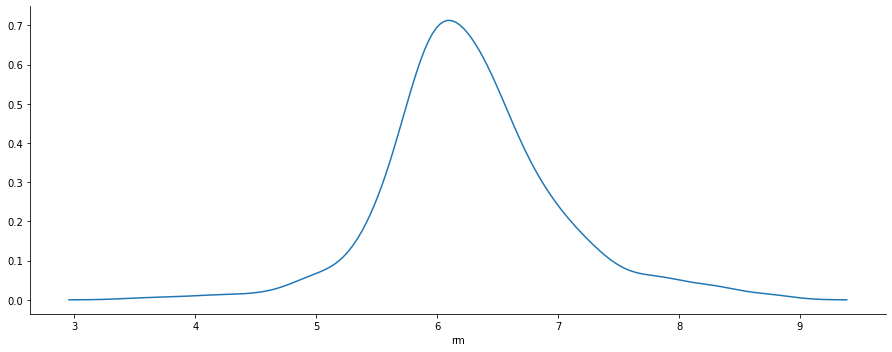

In [8]:
#using searborn facetgrid
sns.FacetGrid(df, height=5, aspect=2.5).map(sns.kdeplot, "rm")

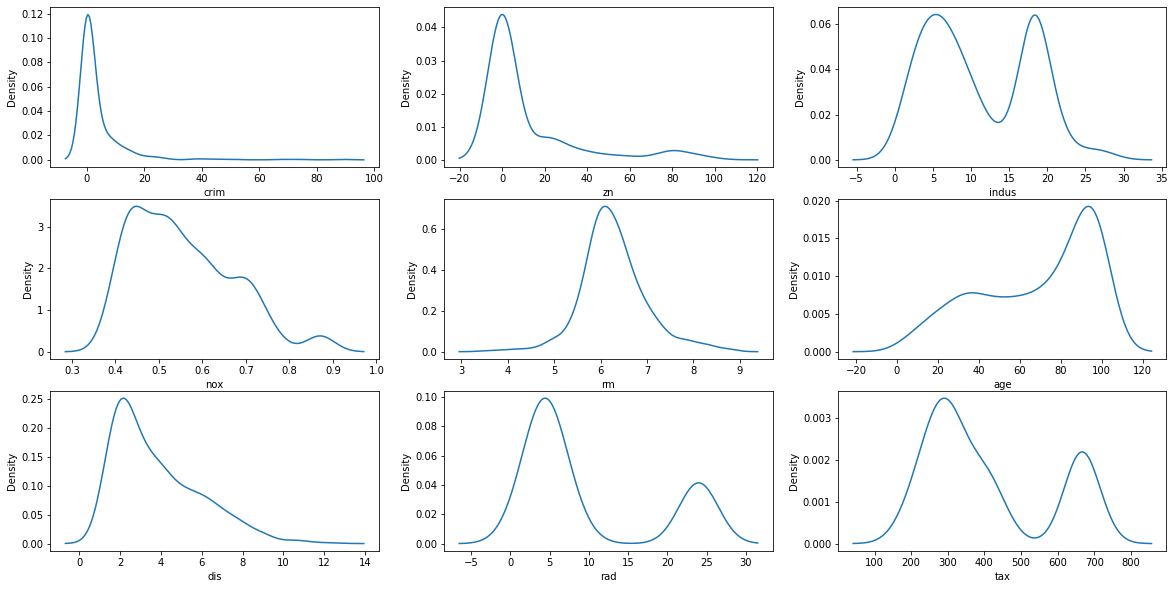

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(20, 10)
cnt = 0
for i in range(0,3):
    for j in range(0,3):
        sns.kdeplot(data=df[col_list[cnt]], ax=axs[i,j]); cnt += 1
        ax.set_title(col_list[cnt])
        ax.grid()

In [10]:
def kde_plot(input_feature):
    #getting log values 
    df['log_times']=[math.log(i) for i in df[input_feature].values]
    #getting kde plot
    fig = sns.FacetGrid(df, size=5.5, aspect=2.2).map(sns.kdeplot, "log_times")
    fig.set_axis_labels('log_values', 'probabilities')
    pt.show()

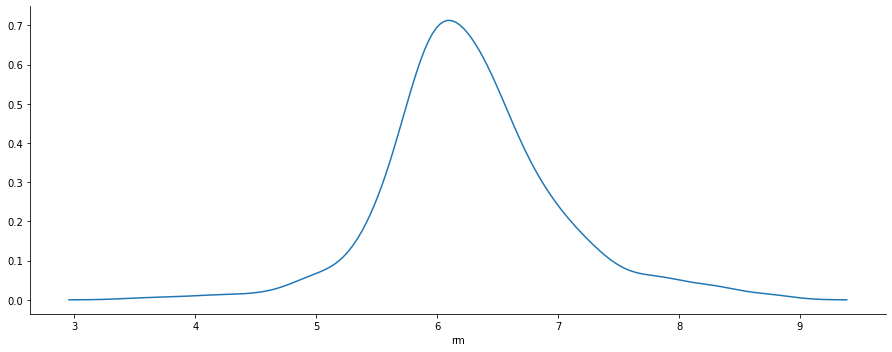

In [11]:
#using searborn facetgrid
sns.FacetGrid(df, height=5, aspect=2.5).map(sns.kdeplot, "rm")

# Q Q Plot

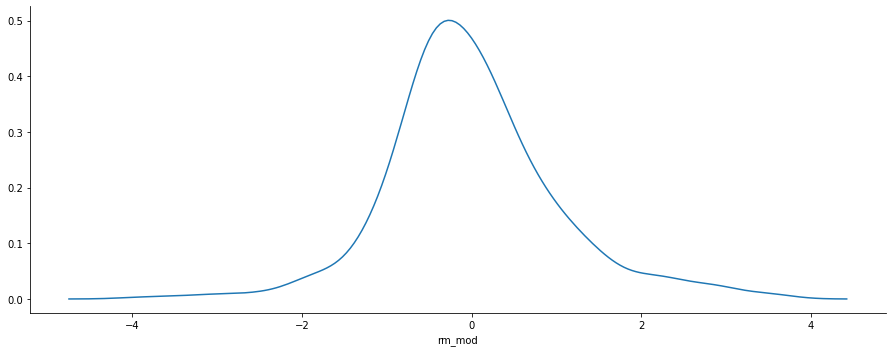

In [12]:
#scaling the feature using standardscaler
from sklearn.preprocessing import StandardScaler
sd = StandardScaler()
rm_mod = sd.fit_transform(df["rm"].values.reshape(-1,1))
rm_mod = rm_mod.reshape(rm_mod.shape[0],)
df["rm_mod"] = pd.Series(rm_mod)
#using searborn facetgrid
sns.FacetGrid(df, height=5, aspect=2.5).map(sns.kdeplot, "rm_mod")

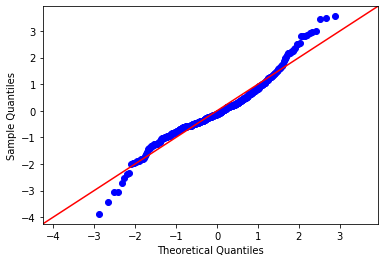

In [13]:
##qq plot
sm.qqplot(df["rm_mod"], line ='45') 
plt.show() 

# Semi-Synthetic Data Experiment for 1 Dimensional Censored Gaussian Distributions 

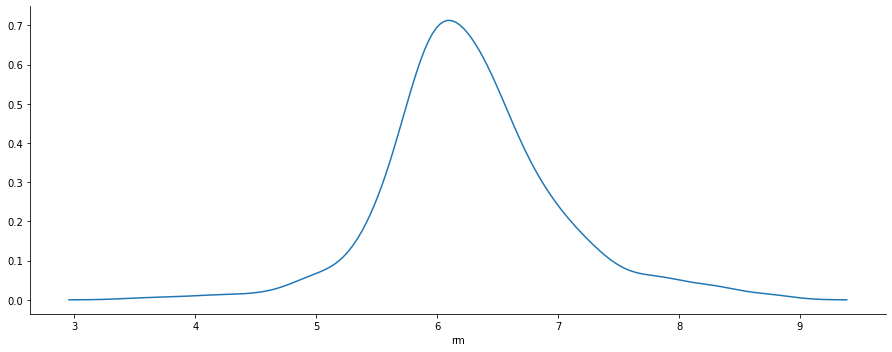

In [14]:
#using searborn facetgrid
sns.FacetGrid(df, height=5, aspect=2.5).map(sns.kdeplot, "rm")


In [76]:
def bootstrap(S, num_samples): 
    idx = ch.randint(S.size(0), (num_samples,))
    S_ = ch.cat([S, S[idx]])
    perm = ch.randperm(len(S_))
    return S_[perm]

# Debias 1D Normal Distributions with Known Truncation

In [77]:
samples = Tensor(df['rm'])[...,None]
samples

tensor([[6.5750],
        [6.4210],
        [7.1850],
        [6.9980],
        [7.1470],
        [6.4300],
        [6.0120],
        [6.1720],
        [5.6310],
        [6.0040],
        [6.3770],
        [6.0090],
        [5.8890],
        [5.9490],
        [6.0960],
        [5.8340],
        [5.9350],
        [5.9900],
        [5.4560],
        [5.7270],
        [5.5700],
        [5.9650],
        [6.1420],
        [5.8130],
        [5.9240],
        [5.5990],
        [5.8130],
        [6.0470],
        [6.4950],
        [6.6740],
        [5.7130],
        [6.0720],
        [5.9500],
        [5.7010],
        [6.0960],
        [5.9330],
        [5.8410],
        [5.8500],
        [5.9660],
        [6.5950],
        [7.0240],
        [6.7700],
        [6.1690],
        [6.2110],
        [6.0690],
        [5.6820],
        [5.7860],
        [6.0300],
        [5.3990],
        [5.6020],
        [5.9630],
        [6.1150],
        [6.5110],
        [5.9980],
        [5.8880],
        [7

In [78]:
gt_loc = Tensor([samples.mean(0)])
gt_var = Tensor([samples.var(0)])[...,None]

print("ground truth mean: ", gt_loc)
print("ground truth variance: ", gt_var)

ground truth mean:  tensor([6.2846])
ground truth variance:  tensor([[0.4937]])


In [79]:
M = MultivariateNormal(gt_loc, gt_var)

alpha: 0.658102766798419


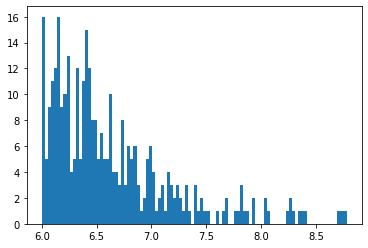

In [80]:
phi = oracle.Left_Distribution(Tensor([6.0]))
# phi = oracle.Identity()
indices = phi(samples).nonzero()[:,0]
S = samples[indices]
alpha = S.size(0) / samples.size(0)
print("alpha: {}".format(alpha))

plt.hist(S.flatten(), bins=100)
plt.show()

In [83]:
S = bootstrap(S, 100)

In [84]:
emp_loc = S.mean(0)
print("empirical mean: ", emp_loc)
emp_var = S.var(0)[...,None]
emp_scale = ch.sqrt(emp_var)

print("empirical scale: ", emp_scale)

emp = MultivariateNormal(emp_loc, emp_var)

S_norm = (S - emp_loc) / emp_scale
phi_norm = oracle.Left_Distribution((phi.left - emp_loc) / emp_scale)

empirical mean:  tensor([6.6509])
empirical scale:  tensor([[0.5786]])


Run algorithm to Remove Bias from the Dataset

In [89]:
censored = CensoredNormal(phi_norm, 
                          alpha, 
                          kwargs={'epochs': 5, 
                          'batch_size': 100, 
                          'num_samples': 100,
                          'step_lr': 500,
                          'lr': 1e-1})
censored.fit(S_norm)
rescale_loc = censored.loc * emp_scale + emp_loc
rescale_var = censored.variance * emp_var
m = MultivariateNormal(rescale_loc, rescale_var)
print("estimated mean: ", rescale_loc)
print("estimated variance: ", rescale_var)

estimated mean:  tensor([[6.4579]])
estimated variance:  tensor([[0.4431]])


In [90]:
print("censored kl divergence: ", kl_divergence(m, M))
print("empirical kl divergence: ", kl_divergence(emp, M))

censored kl divergence:  tensor([0.0332])
empirical kl divergence:  tensor(0.1691)


In [27]:
args.out_dir + '/' + args.exp

'/Users/patroklos/Desktop/exp/censored/boston_'

In [93]:
store = Store(args.out_dir + '/' + args.exp)

schema = { 
    'kl_div_emp': float, 
    'kl_div_censored': float,
    'c': int,
    'alpha': float,
}

# ground-truth boston housing dataset distribution
gt_loc = Tensor([samples.mean(0)])
gt_var = Tensor([samples.var(0)])[...,None]
gt_dist = MultivariateNormal(gt_loc, gt_var)

C = [3.0, 4.0, 5.0, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0]

store.add_table(args.table_name, schema)

for i in range(args.trials): 
    for c in C:
        phi = oracle.Left_Distribution(Tensor([c]))
        indices = phi(samples).nonzero()[:,0]
        S = samples[indices]
        S = bootstrap(S, 1000)
        alpha = S.size(0) / samples.size(0)

        emp_dist = MultivariateNormal(S.mean(0), S.var(0) * ch.ones(1, 1))

        S_norm = (S - emp_dist.loc) / ch.sqrt(emp_dist.covariance_matrix) 
        phi_norm = oracle.Left_Distribution((phi.left - emp_dist.loc) / ch.sqrt(emp_dist.covariance_matrix))


        censored = CensoredNormal(phi_norm, 
                                 alpha, 
                                  {'epochs': 5, 
                                    'batch_size': 100, 
                                    'num_samples': 100,
                                    'lr': 1e-1, 
                                    'step_lr': 500})
        censored.fit(S_norm)


        loc_ = (censored.loc * ch.sqrt(emp_dist.covariance_matrix)) + emp_dist.loc
        scale_ = censored.variance * emp_dist.covariance_matrix

        censor_dist = MultivariateNormal(loc_, scale_)

        kl_censor = float(kl_divergence(gt_dist, censor_dist))
        kl_emp = float(kl_divergence(gt_dist, emp_dist))


        store[args.table_name].update_row({ 
            'kl_div_emp': kl_emp, 
            'kl_div_censored': kl_censor,
            'alpha': alpha,
            'c': c,
        })
        store[args.table_name].flush_row()
        
        IPython.display.clear_output()

    
store.close()

Logging in: /Users/patroklos/Desktop/exp/censored/boston_bootstrap/960e4313-2212-461c-9495-ce8a2f29b7ba
c:  3.0
alpha:  2.9762845849802373
kl censor:  0.08999225497245789
c:  4.0
alpha:  2.972332015810277
kl censor:  0.06623271107673645
c:  5.0
alpha:  2.9446640316205532
kl censor:  0.03295254707336426
c:  5.5
alpha:  2.8932806324110674
kl censor:  0.04519188404083252
c:  5.75
alpha:  2.8122529644268774
kl censor:  0.06091032922267914
c:  6.0
alpha:  2.6343873517786562
kl censor:  0.028142020106315613
c:  6.25
alpha:  2.438735177865613
kl censor:  0.043786197900772095
c:  6.5
alpha:  2.2766798418972334
kl censor:  0.13616928458213806
c:  6.75
alpha:  2.175889328063241
kl censor:  0.3220382332801819
c:  7.0
alpha:  2.102766798418972
kl censor:  0.6650757789611816
c:  3.0
alpha:  2.9762845849802373
kl censor:  0.08274884521961212
c:  4.0
alpha:  2.972332015810277
kl censor:  0.06615379452705383
c:  5.0
alpha:  2.9446640316205532
kl censor:  0.037005096673965454
c:  5.5
alpha:  2.89328063

kl censor:  0.07185417413711548
c:  5.0
alpha:  2.9446640316205532
kl censor:  0.04386250674724579
c:  5.5
alpha:  2.8932806324110674
kl censor:  0.05628290772438049
c:  5.75
alpha:  2.8122529644268774
kl censor:  0.05851359665393829
c:  6.0
alpha:  2.6343873517786562
kl censor:  0.02754931151866913
c:  6.25
alpha:  2.438735177865613
kl censor:  0.041044995188713074
c:  6.5
alpha:  2.2766798418972334
kl censor:  0.17402759194374084
c:  6.75
alpha:  2.175889328063241
kl censor:  0.2454673945903778
c:  7.0
alpha:  2.102766798418972
kl censor:  0.6253976821899414
c:  3.0
alpha:  2.9762845849802373
kl censor:  0.11744141578674316
c:  4.0
alpha:  2.972332015810277
kl censor:  0.10070396959781647
c:  5.0
alpha:  2.9446640316205532
kl censor:  0.044845253229141235
c:  5.5
alpha:  2.8932806324110674
kl censor:  0.038124457001686096
c:  5.75
alpha:  2.8122529644268774
kl censor:  0.054157331585884094
c:  6.0
alpha:  2.6343873517786562
kl censor:  0.018532469868659973
c:  6.25
alpha:  2.43873517

In [94]:
reader = CollectionReader(args.out_dir + '/' + args.exp)
logs = reader.df(args.table_name)
reader.close()
logs.head(10)

100%|██████████| 1/1 [00:00<00:00, 110.99it/s]


,kl_div_emp,kl_div_censored,c,alpha,exp_id
0,0.001003,0.089992,3,2.976285,960e4313-2212-461c-9495-ce8a2f29b7ba
1,0.002644,0.066233,4,2.972332,960e4313-2212-461c-9495-ce8a2f29b7ba
2,0.016573,0.032953,5,2.944664,960e4313-2212-461c-9495-ce8a2f29b7ba
3,0.041666,0.045192,5,2.893281,960e4313-2212-461c-9495-ce8a2f29b7ba
4,0.082148,0.060910,5,2.812253,960e4313-2212-461c-9495-ce8a2f29b7ba
5,0.268349,0.028142,6,2.634387,960e4313-2212-461c-9495-ce8a2f29b7ba
6,0.592678,0.043786,6,2.438735,960e4313-2212-461c-9495-ce8a2f29b7ba
7,1.265258,0.136169,6,2.276680,960e4313-2212-461c-9495-ce8a2f29b7ba
8,2.134181,0.322038,6,2.175889,960e4313-2212-461c-9495-ce8a2f29b7ba
9,3.704010,0.665076,7,2.102767,960e4313-2212-461c-9495-ce8a2f29b7ba


In [95]:
print("kl emp div: {}".format(logs.kl_div_emp.mean()))
print("kl censor div: {}".format(logs.kl_div_censored.mean()))

kl emp div: 0.8238013501465321
kl censor div: 0.1461461668461561


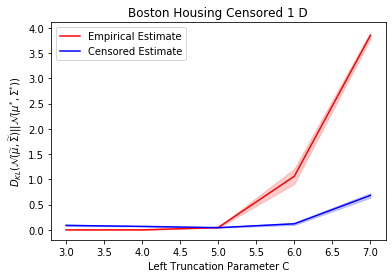

In [98]:
sns.lineplot(data=logs, x='c', y='kl_div_emp', color='red', label='Empirical Estimate')
ax = sns.lineplot(data=logs, x='c', y='kl_div_censored', color='blue', label='Censored Estimate')
ax.set_title('Censored Normal Distribution - Vary')
ax.set_xlabel('Left Truncation Parameter C')
ax.set_ylabel('$D_{KL}(\mathcal{N}(\widetilde{\mu}, \widetilde{\Sigma}) || \mathcal{N}(\mu^{*}, \Sigma^{*}))$')
ax.set_title('Boston Housing Censored 1 D')
ax.legend()
plt.show()

# Debias 1D Distributions with Unknown Truncation

In [100]:
from delphi.distributions.truncated_normal import TruncatedNormal

alpha: 0.658102766798419


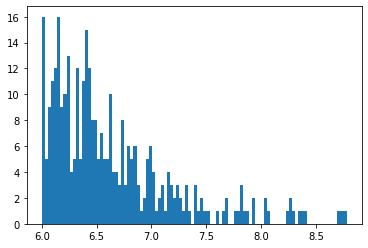

In [101]:
# truncate dataset 

phi = oracle.Left_Distribution(Tensor([6.0]))
# phi = oracle.Identity()
indices = phi(samples).nonzero()[:,0]
S = samples[indices]
alpha = S.size(0) / samples.size(0)
print("alpha: {}".format(alpha))

plt.hist(S.flatten(), bins=100)
plt.show()

In [102]:
emp_loc = S.mean(0)
print("empirical mean: ", emp_loc)
emp_var = S.var(0)[...,None]
emp_scale = ch.sqrt(emp_var)

print("empirical scale: ", emp_scale)

emp = MultivariateNormal(emp_loc, emp_var)

S_norm = (S - emp_loc) / emp_scale
phi_norm = oracle.Left_Distribution((phi.left - emp_loc) / emp_scale)

empirical mean:  tensor([6.6275])
empirical scale:  tensor([[0.5613]])


In [104]:
S_norm = bootstrap(S_norm, 1000)

In [105]:
truncated = TruncatedNormal(alpha, 
                           {'batch_size': 100,})
truncated.fit(S_norm)

rescale_loc = truncated.loc * emp_scale + emp_loc
rescale_var = truncated.variance * emp_var
m = MultivariateNormal(rescale_loc, rescale_var)
print("estimated mean: ", rescale_loc)
print("estimated variance: ", rescale_var)

estimated mean:  tensor([[6.4399]])
estimated variance:  tensor([[0.7658]])


/Users/patroklos/Desktop/delphi_/delphi/utils/helpers.py:377: UserWarning: unknown argument: alpha. procedure will continue, but results may not be as expected.
  warnings.warn("unknown argument: {}. procedure will continue, but results may not be as expected.".format(arg_name))


In [106]:
print("censored kl divergence: ", kl_divergence(m, M))
print("empirical kl divergence: ", kl_divergence(emp, M))

censored kl divergence:  tensor([0.0805])
empirical kl divergence:  tensor(0.1628)


In [108]:
store = Store(args.out_dir + '/' + args.exp)

schema = { 
    'kl_div_emp': float, 
    'kl_div_trunc': float,
    'c': int,
    'alpha': float,
}

# ground-truth boston housing dataset distribution
gt_loc = Tensor([samples.mean(0)])
gt_var = Tensor([samples.var(0)])[...,None]
gt_dist = MultivariateNormal(gt_loc, gt_var)

C = [3.0, 4.0, 5.0, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0]

store.add_table(args.table_name, schema)

for i in range(args.trials): 
    for c in C:
        phi = oracle.Left_Distribution(Tensor([c]))
        indices = phi(samples).nonzero()[:,0]
        S = samples[indices]
        S = bootstrap(S, 1000)
        alpha = S.size(0) / samples.size(0)

        emp_dist = MultivariateNormal(S.mean(0), S.var(0) * ch.ones(1, 1))

        S_norm = (S - emp_dist.loc) / ch.sqrt(emp_dist.covariance_matrix) 


        truncated = TruncatedNormal(alpha, 
                                  {'epochs': 5, 
                                    'batch_size': 100, 
                                    'lr': 1e-1, 
                                    'step_lr': 500})
        truncated.fit(S_norm)


        loc_ = (truncated.loc * ch.sqrt(emp_dist.covariance_matrix)) + emp_dist.loc
        scale_ = truncated.variance * emp_dist.covariance_matrix

        trunc_dist = MultivariateNormal(loc_, scale_)

        kl_censor = float(kl_divergence(gt_dist, trunc_dist))
        kl_emp = float(kl_divergence(gt_dist, emp_dist))


        store[args.table_name].update_row({ 
            'kl_div_emp': kl_emp, 
            'kl_div_trunc': kl_censor,
            'alpha': alpha,
            'c': c,
        })
        store[args.table_name].flush_row()
        
        IPython.display.clear_output()

    
store.close()

In [110]:
reader = CollectionReader(args.out_dir + '/' + args.exp)
logs = reader.df(args.table_name)
reader.close()
logs.head(10)

100%|██████████| 2/2 [00:00<00:00, 117.47it/s]

new schema missing keys: {'kl_div_censored'}, new keys: {'kl_div_trunc'}



/opt/anaconda3/lib/python3.7/site-packages/cox-0.1.post3-py3.7.egg/cox/readers.py:160: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  catted = pd.concat(tables)


,alpha,c,exp_id,kl_div_censored,kl_div_emp,kl_div_trunc
0,2.976285,3,960e4313-2212-461c-9495-ce8a2f29b7ba,0.089992,0.001003,NaN
1,2.972332,4,960e4313-2212-461c-9495-ce8a2f29b7ba,0.066233,0.002644,NaN
2,2.944664,5,960e4313-2212-461c-9495-ce8a2f29b7ba,0.032953,0.016573,NaN
3,2.893281,5,960e4313-2212-461c-9495-ce8a2f29b7ba,0.045192,0.041666,NaN
4,2.812253,5,960e4313-2212-461c-9495-ce8a2f29b7ba,0.060910,0.082148,NaN
5,2.634387,6,960e4313-2212-461c-9495-ce8a2f29b7ba,0.028142,0.268349,NaN
6,2.438735,6,960e4313-2212-461c-9495-ce8a2f29b7ba,0.043786,0.592678,NaN
7,2.276680,6,960e4313-2212-461c-9495-ce8a2f29b7ba,0.136169,1.265258,NaN
8,2.175889,6,960e4313-2212-461c-9495-ce8a2f29b7ba,0.322038,2.134181,NaN
9,2.102767,7,960e4313-2212-461c-9495-ce8a2f29b7ba,0.665076,3.704010,NaN


In [112]:
print("kl emp div: {}".format(logs.kl_div_emp.mean()))
print("kl trunc div: {}".format(logs.kl_div_trunc.mean()))

kl emp div: 0.8281039588153363
kl trunc div: 0.15071661844849588


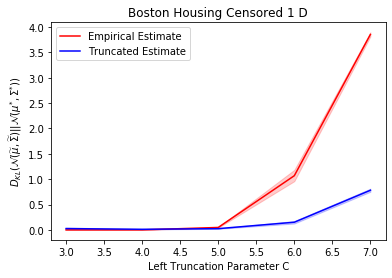

In [114]:
sns.lineplot(data=logs, x='c', y='kl_div_emp', color='red', label='Empirical Estimate')
ax = sns.lineplot(data=logs, x='c', y='kl_div_trunc', color='blue', label='Truncated Estimate')
ax.set_title('Truncated Normal Distribution - Varying Truncation Parameter C')
ax.set_xlabel('Left Truncation Parameter C')
ax.set_ylabel('$D_{KL}(\mathcal{N}(\widetilde{\mu}, \widetilde{\Sigma}) || \mathcal{N}(\mu^{*}, \Sigma^{*}))$')
ax.set_title('Boston Housing Censored 1 D')
ax.legend()
plt.show()